In [1]:
!pip install opencv-python

In [2]:
!pip install open3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [8]:
import open3d as o3d
import numpy as np


# Load your point cloud
pcd = o3d.io.read_point_cloud("/content/PhotoPoints.pcd")




In [11]:


def project_to_image(pcd, width=640, height=480, fov_deg=90):
    # Camera intrinsics
    fov_rad = fov_deg * np.pi / 180
    f = width / (2 * np.tan(fov_rad / 2))  # Focal length

    # Assuming the camera looks along -Z with Y up and X to the right
    intrinsic_matrix = np.array([
        [f, 0, width / 2],
        [0, f, height / 2],
        [0, 0, 1]
    ])

    # Convert point cloud to numpy array
    points = np.asarray(pcd.points)

    # Ensure no points are NaN or infinite
    mask = ~np.isnan(points).any(axis=1) & ~np.isinf(points).any(axis=1)
    points = points[mask]

    # Check if any Z values are zero, which can't be projected
    points = points[points[:, 2] != 0]

    # Normalize by Z for projection (safe as we removed Z=0 cases)
    points_normalized = points / points[:, 2, np.newaxis]
    pixel_coords = points_normalized @ intrinsic_matrix.T  # Project onto image plane
    pixel_coords = pixel_coords[:, :2]  # Keep only X, Y coordinates

    # Create depth image
    depth_image = np.zeros((height, width), dtype=np.float32)
    for i, (x, y) in enumerate(pixel_coords):
        x, y = int(round(x)), int(round(y))
        if 0 <= x < width and 0 <= y < height:
            z = points[i, 2]
            # Only update if this pixel hasn't been set or if this point is closer
            if depth_image[y, x] == 0 or z < depth_image[y, x]:
                depth_image[y, x] = z

    return depth_image


# Project and visualize the depth image
depth_image = project_to_image(pcd)
if np.any(np.isnan(depth_image)) or np.any(np.isinf(depth_image)):
    print("Error: Depth image contains NaN or inf values.")
else:
    depth_image_normalized = depth_image / np.max(depth_image)  # Normalize for visualization
    o3d.visualization.draw_geometries([o3d.geometry.Image(depth_image_normalized)])


[Open3D WARNING] GLFW Error: X11: The DISPLAY environment variable is missing
[Open3D WARNING] Failed to initialize GLFW
[Open3D WARNING] [DrawGeometries] Failed creating OpenGL window.


<ipython-input-11-163a138a2243>:46: RuntimeWarning: invalid value encountered in divide
  depth_image_normalized = depth_image / np.max(depth_image)  # Normalize for visualization


In [14]:
import cv2

In [16]:
def apply_watershed(depth_image):
    # Convert depth image to 8-bit (required for morphological operations)
    depth_image_8u = np.uint8(depth_image / np.max(depth_image) * 255)

    # Apply threshold to create a binary image
    _, thresh = cv2.threshold(depth_image_8u, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Noise removal using morphological opening
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    # Sure background area (dilate to increase object boundary to background)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area (distance transformation)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers + 1

    # Mark the region of unknown with zero
    markers[unknown == 255] = 0

    # Apply watershed
    markers = cv2.watershed(cv2.cvtColor(depth_image_8u, cv2.COLOR_GRAY2BGR), markers)

    # Mark boundary regions with red
    depth_image_8u[markers == -1] = [255]

    return depth_image_8u, markers

# Load and prepare the depth image
pcd = o3d.io.read_point_cloud("path_to_your_point_cloud.pcd")
depth_image = project_to_image(pcd)
depth_image /= np.max(depth_image)  # Normalize for better visualization and processing

# Apply watershed segmentation
segmented_image, markers = apply_watershed(depth_image)

# Show the result
# cv2.imshow('Segmented Image', segmented_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

[Open3D WARNING] Read PCD failed: unable to open file: path_to_your_point_cloud.pcd


<ipython-input-16-d20d070baf01>:43: RuntimeWarning: invalid value encountered in divide
  depth_image /= np.max(depth_image)  # Normalize for better visualization and processing
<ipython-input-16-d20d070baf01>:3: RuntimeWarning: invalid value encountered in cast
  depth_image_8u = np.uint8(depth_image / np.max(depth_image) * 255)


In [4]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from torchvision.models.quantization import resnet50, ResNet50_QuantizedWeights
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights



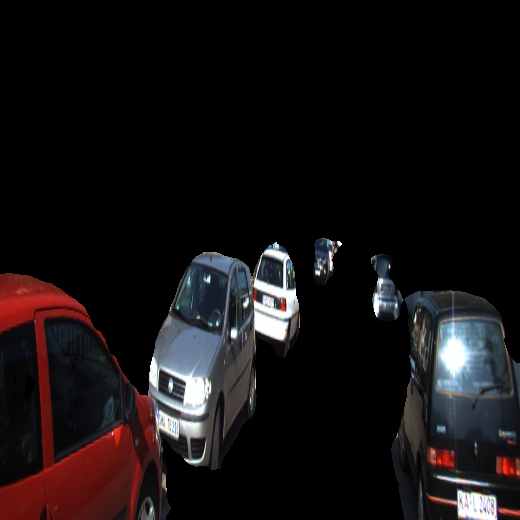

In [10]:
import cv2
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import fcn_resnet50

def load_model():
    # Load a pre-trained FCN ResNet50 model
    model = fcn_resnet50(pretrained=True)
    model.eval()
    return model

def segment_image(image_path, model):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image from {image_path}. Check the file path and permissions.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Prepare the image for the model
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize((520, 520)),  # Resize to the size expected by the model
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    input_image = transform(image).unsqueeze(0)

    # Predict the segmentation
    with torch.no_grad():
        output = model(input_image)['out'][0]
    output_predictions = output.argmax(0)
    return output_predictions.byte().cpu().numpy()

from google.colab.patches import cv2_imshow

def apply_mask(image_path, mask):
    # Load the original image
    original_image = cv2.imread(image_path)
    original_image = cv2.resize(original_image, (520, 520))  # Ensure dimensions match the mask

    # Apply the segmentation mask
    masked_image = original_image.copy()
    masked_image[mask == 0] = 0  # Mask the background (assuming class 0 is background)

    # Display the result using cv2_imshow instead of cv2.imshow
    cv2.imwrite('masked_image.png', masked_image)
    cv2_imshow(masked_image)  # Use cv2_imshow here



def main():
    model = load_model()
    image_path = '/content/PHOTO-2024-05-04-22-46-00.jpg'  # Update with the absolute path to your image
    mask = segment_image(image_path, model)
    apply_mask(image_path, mask)

if __name__ == "__main__":
    main()


In [1]:
import numpy as np
import cv2

def load_depth_map(file_path):
    # Dummy function to load depth map
    # Replace this with actual loading code depending on the format of your depth data
    return cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

def convert_to_3d(mask, depth_map, camera_intrinsics):
    # Extract non-black points (assuming mask is a binary image)
    indices = np.where(mask != 0)

    # Fetch the corresponding depth values
    z_values = depth_map[indices]

    # Extract x and y coordinates from indices
    x_indices, y_indices = indices[1], indices[0]

    # Convert indices to image coordinates
    x_coords = (x_indices - camera_intrinsics['cx']) * z_values / camera_intrinsics['fx']
    y_coords = (y_indices - camera_intrinsics['cy']) * z_values / camera_intrinsics['fy']

    # Stack x, y, z coordinates into a 3D array
    points_3d = np.stack((x_coords, y_coords, z_values), axis=-1)

    return points_3d

# Load mask and depth map
mask = cv2.imread('/content/masked_image.png', cv2.IMREAD_GRAYSCALE)
depth_map = load_depth_map('path_to_depth_map.png')

# Define camera intrinsics
camera_intrinsics = {
    'fx': 525.0,  # Focal length x
    'fy': 525.0,  # Focal length y
    'cx': 319.5,  # Optical center x
    'cy': 239.5   # Optical center y
}

# Convert to 3D points
points_3d = convert_to_3d(mask, depth_map, camera_intrinsics)
print("3D Points shape:", points_3d.shape)


TypeError: 'NoneType' object is not subscriptable